In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
#Declare a Base using 'automap_base()'
Base = automap_base()

In [7]:
# reflect an existing database into a new model
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
#This will show you how many tables there are and then how many maps there will be
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Temperature Analysis 1

In [11]:
#Earliest Date
check_e = session.query(func.min(Measurement.date)).all()
#check_e

In [12]:
#Latest Date
check_l = session.query(func.max(Measurement.date)).all()
#check_l

In [13]:
#Identify the average temperature in June at all stations across all available years in the dataset. 
month_june = "06"

june_avg = session.query(func.avg(Measurement.tobs))\
    .group_by(Measurement.station)\
    .filter(func.strftime("%m", Measurement.date) == month_june).all()
june_avg

[(74.13939393939394),
 (74.05084745762711),
 (76.00537634408602),
 (71.9372197309417),
 (76.6554054054054),
 (73.39473684210526),
 (73.27118644067797),
 (77.55932203389831),
 (76.66810344827586)]

In [14]:
#Do the same for December temperature.
month_dec = "12"

dec_avg = session.query(func.avg(Measurement.tobs))\
    .group_by(Measurement.station)\
    .filter(func.strftime("%m", Measurement.date) == month_dec).all()
dec_avg

[(69.6842105263158),
 (71.06944444444444),
 (73.2247191011236),
 (69.29126213592232),
 (71.8348623853211),
 (72.42105263157895),
 (69.90322580645162),
 (71.10952380952381),
 (72.43333333333334)]

<font size=4>Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
Will you use a paired t-test, or an unpaired t-test? Why?</font>

In [15]:
# Statistical analysis
from scipy import stats
from numpy import mean

In [16]:
mean(june_avg)

74.85351018249018

In [17]:
mean(dec_avg)

71.21907046377945

In [18]:
#Paired ttest - because we're comparing means of the same group
stats.ttest_ind(june_avg, dec_avg, equal_var=False)

Ttest_indResult(statistic=array([4.61586542]), pvalue=array([0.00036573]))

P-value is 0.0003 < 0.05, therefore data is valid, no significant difference between temperature in June and December in Hawaii.

# Temperature Analysis 2

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
# def calc_temps(start_date, end_date):
#     """TMIN, TAVG, and TMAX for a list of dates.
    
#     Args:
#         start_date (string): A date string in the format %Y-%m-%d
#         end_date (string): A date string in the format %Y-%m-%d
        
#     Returns:
#         TMIN, TAVE, and TMAX
#     """
    
#     return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
#         filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# # function usage example
# print(calc_temps('2012-02-28', '2012-03-05'))

In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
# print(calc_temps('2017-04-09', '2017-04-15'))

#Assign a variable to to results to set up Data Frame for plot
temperature = calc_temps('2017-04-09', '2017-04-15')
temperature

[(67.0, 74.24444444444444, 82.0)]

In [21]:
#Convert to Data Frame for plot
results = pd.DataFrame(temperature, columns=["TMIN", "TAVE", "TMAX"])
results

,TMIN,TAVE,TMAX
0,67.0,74.244444,82.0


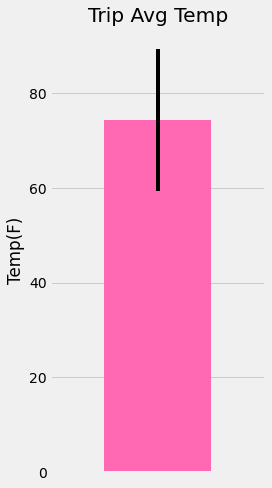

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(4,7))
trip_plot = results['TAVE'].plot(kind='bar', yerr=(results['TMAX']-results['TMIN']), color='hotpink')
plt.ylabel('Temp(F)')
trip_plot.axes.get_xaxis().set_ticks([])
plt.title('Trip Avg Temp')
plt.tight_layout()

# Daily Rainfall Average

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-04-09'
end_date = '2017-04-15'

# Create a list of dates for your trip
date_range = {'dates': ['2017-04-09', '2017-04-10', '2017-04-11', '2017-04-12', '2017-04-13', '2017-04-14', '2017-04-15']}

#Datetime data type
convert_range = pd.DataFrame(date_range, columns=['dates'])
year_date = convert_range['dates'] = pd.to_datetime(convert_range['dates'], format='%Y-%m-%d')

#Strip off the year and save a list of %m-%d strings
month_day = convert_range['dates'] = convert_range['dates'].dt.strftime('%m-%d')
list_dates = convert_range['dates'].to_list()
# list_dates

In [25]:
#Loop through the list of %m-%d strings and calculate the normals for each date
norms = [daily_normals(date) for date in list_dates]
norm_list = [item for sublist in norms for item in sublist]
norm_list

[(62.0, 71.6140350877193, 78.0),
 (64.0, 71.40350877192982, 79.0),
 (65.0, 72.49180327868852, 82.0),
 (65.0, 72.22413793103448, 80.0),
 (64.0, 71.52542372881356, 79.0),
 (65.0, 72.75, 81.0),
 (61.0, 71.79310344827586, 79.0)]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_data = pd.DataFrame(norm_list, columns=['TMIN', 'TAVG', 'TMAX'], index=year_date)
trip_data.index.name="DATE"
trip_data

,TMIN,TAVG,TMAX
DATE,,,
2017-04-09,62.0,71.614035,78.0
2017-04-10,64.0,71.403509,79.0
2017-04-11,65.0,72.491803,82.0
2017-04-12,65.0,72.224138,80.0
2017-04-13,64.0,71.525424,79.0
2017-04-14,65.0,72.750000,81.0
2017-04-15,61.0,71.793103,79.0


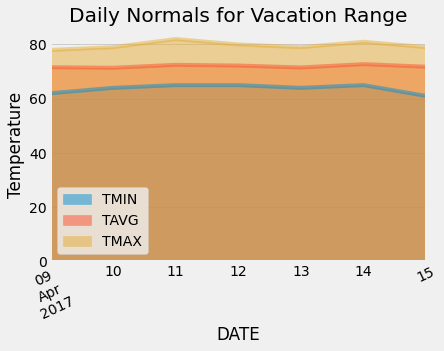

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
ax = trip_data.plot.area(stacked=False)
plt.xticks(rotation=25)
plt.ylabel('Temperature')
plt.title('Daily Normals for Vacation Range')
plt.show()